# Create subset dataset of Open TG-GATEs

In [1]:
import random
import gc
import collections
import datetime
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

root = "/workspace/tggate"
seed=24771

random.seed(seed)

In [2]:
print(datetime.datetime.today().strftime("%Y/%m/%d %H:%M:%S"))

2024/01/11 16:53:23


In [3]:
# load
info_df = pd.read_csv(f"{root}/data/processed/info.csv")
print(info_df.shape)
info_df = info_df.dropna(subset=["FILE"])
print(info_df.shape)
info_df["GROUP"] = 100 * info_df["EXP_ID"] + info_df["GROUP_ID"]
lst_compounds=[line.rstrip() for line in open(f"{root}/data/processed/compound_list.txt", "r")]
lst_findings=[line.rstrip() for line in open(f"{root}/data/processed/finding_lst.txt", "r")]

(23873, 311)
(23317, 311)


/tmp/ipykernel_60599/863299380.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  info_df = pd.read_csv(f"{root}/data/processed/info.csv")


In [4]:
# remove scar and dead from findings
lst_findings.remove("Scar")
lst_findings.remove("DEAD")

In [5]:
print((info_df.loc[:,lst_findings].sum(axis=1)>0).sum())
print(collections.Counter(info_df[info_df.loc[:,lst_findings].sum(axis=1)>0]["DOSE_LEVEL"].tolist()))

3857
Counter({'High': 1883, 'Middle': 1128, 'Low': 543, 'Control': 303})


In [6]:
# at least one finding label samples
df_true=info_df[info_df.loc[:,lst_findings].sum(axis=1)>0].copy()

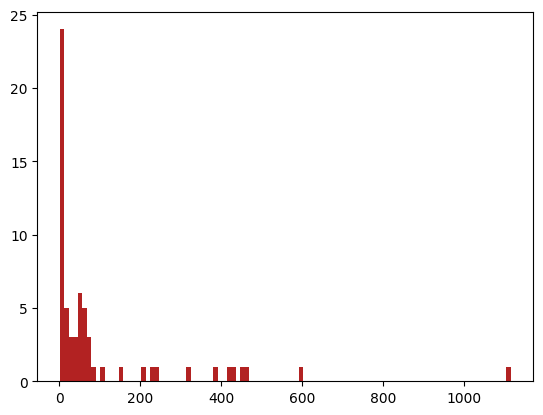

In [7]:
plt.hist(df_true.loc[:,lst_findings].sum(), color="firebrick", bins=100)
plt.show()

In [8]:
# one sample from each group
df_false_all=info_df[info_df.loc[:,lst_findings].sum(axis=1)==0].copy()
lst_group=list(set(df_false_all["GROUP"].tolist()))
len(lst_group)

4274

In [9]:
# extract samples (one sample for each group)
df_false=list()
for group in tqdm(lst_group):
    df_temp = pd.DataFrame(df_false_all[df_false_all["GROUP"]==group])
    df_false.append(df_temp.iloc[random.sample(range(df_temp.shape[0]),1),:])
df_false=pd.concat(df_false, axis=0)

100%|██████████| 4274/4274 [00:02<00:00, 2021.90it/s]


In [10]:
print(collections.Counter(df_false["DOSE_LEVEL"].tolist()))

Counter({'Control': 1182, 'Low': 1136, 'Middle': 1050, 'High': 906})


In [11]:
def make_groupkfold(group_col, n_splits:int=5):
    temp_arr = np.zeros((len(group_col),1))
    kfold = GroupKFold(n_splits = n_splits).split(temp_arr, groups=group_col)
    kfold_arr = np.zeros((len(group_col),1), dtype=int)
    for n, (tr_ind, val_ind) in enumerate(kfold):
        kfold_arr[val_ind]=int(n)
    return kfold_arr

def set_dir(lst_time, lst_file):
    lst_dir=[]
    for time, filename in zip(lst_time, lst_file):
        if "hr" in time:
            folder="/workspace/HDD2/TGGATEs/WSI/Liver" #change to your dir
        else:
            folder="/workspace/HDD1/TGGATEs/WSI/Liver" #change to your dir
        time2=time.replace(" ", "_")
        lst_dir.append(f"{folder}/{time2}/{filename}")
    return lst_dir
    
n_splits=5

In [12]:
# concat
df_all=pd.concat([df_true, df_false], axis=0)
# Set folder
df_all["DIR"]=set_dir(df_all["SACRI_PERIOD"].tolist(), df_all["FILE"].tolist())
# Set Folding
df_all["FOLD"]=make_groupkfold(
    df_all["GROUP"], n_splits=n_splits
)

In [13]:
# export
df_all.to_csv(f"{root}/data/tggate_info_ext.csv", index=False)
print(datetime.datetime.today().strftime("%Y/%m/%d %H:%M:%S"))

2024/01/11 16:53:30


In [14]:
# file location
lst_time=list(set(df_all["SACRI_PERIOD"]))
for time in lst_time:
    df_temp = df_all[df_all["SACRI_PERIOD"]==time]
    time2=time.replace(" ", "_")
    df_temp["FILE_LOCATION"].to_csv(f"{root}/data/filelocation/{time2}.txt", index=False)